In [114]:
import numpy as np
from sklearn import datasets

from NPIR import NPIR
import pandas as pd
from sklearn.datasets import make_blobs
import datetime
import warnings
from sklearn import metrics
from collections import Counter as Cs

In [201]:
x,y  = make_blobs(n_samples=100, centers=3, n_features=2,
                random_state=0)


In [116]:
x1,y1 = make_blobs(n_samples=100, centers=3, n_features=2,
                random_state=1)

In [117]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.15
#The number of iteration i
i = 50
k = 3 #k: Number of clusters
# count = Cs()

In [118]:
# labelsPred = NPIR(x,k,IR,i)
labelsPred1 = NPIR(x1,k,IR,i)

In [153]:
# xf = pd.DataFrame(x)
# xf['label'] = labelsPred

xf1 = pd.DataFrame(x1)
xf1['label'] = labelsPred1


In [154]:
f = list(Cs(labelsPred1))
f.sort()
f

[0, 1, 2]

In [155]:
leader = []
f = list(Cs(labelsPred))
f.sort()
for i in f:
    leader.append([np.mean(z) for z in xf[xf['label']==i].values[:,:-1].T])
leader

[[0.5441920931435794, 3.77522645627156],
 [-2.259688256037324, 2.9662157924778776],
 [2.2693904012551105, 1.2126059775227027]]

In [156]:
leader1 = []
f = list(Cs(labelsPred1))
f.sort()
for i in f:
    leader1.append([np.mean(z) for z in xf1[xf1['label']==i].values[:,:-1].T])
leader1

[[-10.049352425116377, -3.859540950538311],
 [-6.581967860885246, -8.172393393876066],
 [-1.471081503636663, 4.337218821035101]]

In [157]:
centers = leader.copy()
centers.extend(leader1)

In [158]:
newlabel = NPIR(centers,k,IR,i)
newlabel

array([0, 0, 2, 1, 1, 0], dtype=object)

In [207]:

xf['newlabel'] = np.full(len(xf), np.nan)
xf1['newlabel'] =np.full(len(xf1), np.nan)
f = list(Cs(labelsPred))
f.sort()
for i in range(len(f)):
    xf.loc[xf['label'] == f[i],'newlabel'] = newlabel[:len(f)][i]

f = list(Cs(labelsPred1))
f.sort()
for i in range(len(f)):
    xf1.loc[xf1['label'] == f[i],'newlabel'] = newlabel[-len(f):][i]
merged_data = xf.append(xf1)
merged_data['label'] = merged_data['newlabel']
merged_data.drop(['newlabel'], inplace =True,axis=1)
merged_data.reset_index(inplace=True)
merged_data.drop(['index'], inplace =True,axis=1)
merged_data

,0,1,label
0,2.631858,0.689365,2.0
1,0.080804,4.690690,0.0
2,3.002519,0.742654,2.0
3,-0.637628,4.091047,0.0
4,-0.072283,2.883769,0.0
...,...,...,...
195,-6.026058,-5.966248,1.0
196,-7.047473,-9.275247,1.0
197,-1.373973,5.291631,0.0
198,-6.253931,-7.108786,1.0


In [ ]:
xf = merged_data.copy()
labelsPred = merged_data['label']

In [24]:
tStart = datetime.datetime.now()

In [25]:
labelsPred = NPIR(x,k,IR,i)

In [26]:
#printing results
print('labels:')
print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

labels:
[2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 2 0 0 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 1 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2]
Time: 0:00:05.841380
Measures:
HS: 0.15514209092195833
CS: 0.35386610131606167
VM: 0.21571176142840348
AMI: 0.1916659801095808
ARI: 0.06939194722159252


In [27]:
# x

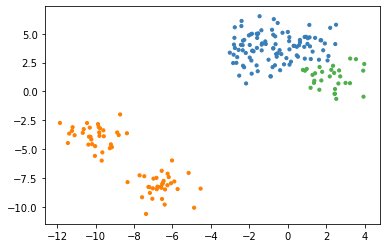

In [218]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(merged_data.iloc[:, 0].values, merged_data.iloc[:, 1].values, s=10, color=colors[merged_data['label'].astype(int).tolist()])
plt.show()
# plt.clf()

In [219]:
# [merged_data['label'].astype(int).tolist()]